<a href="https://colab.research.google.com/github/OswaldVc/AnaDat/blob/main/Medical_Image_Classification_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

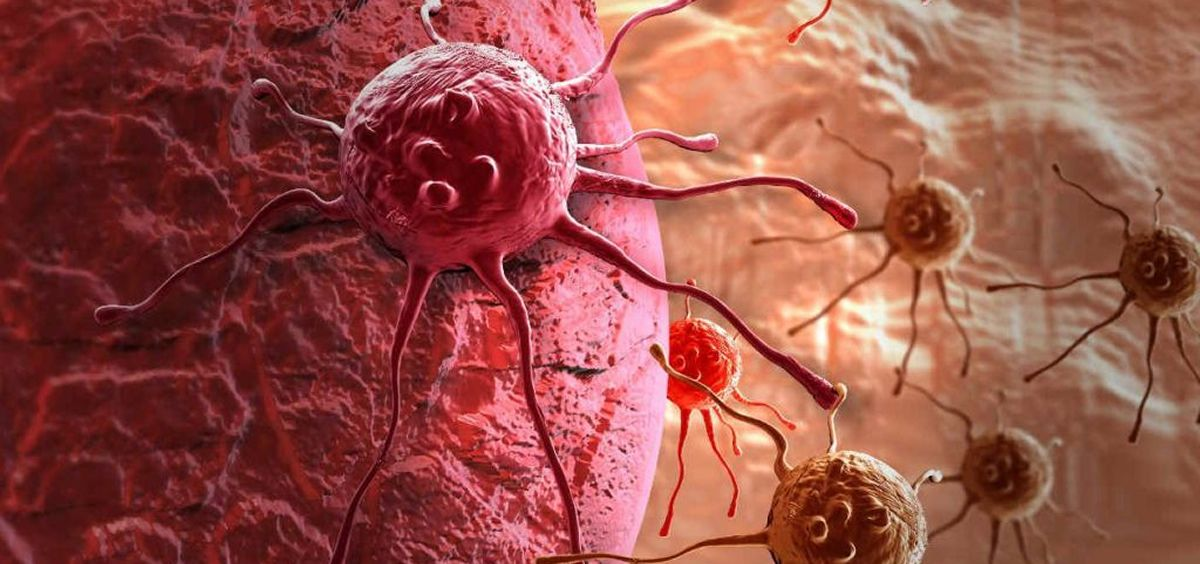


>>Néstor O. Vásquez C.

*En este cuaderno crearemos un algoritmo que utiliza aprendizaje profundo y visión por computadora para identificar el cáncer metastásico en pequeños parches de imágenes tomadas de exploraciones patológicas digitales más grandes.*

In [1]:
%%capture
## instalación libreria
! pip install --upgrade torch

In [2]:
%%capture
## instalación libreria
!pip install skillsnetwork

In [7]:
###  ------------------ librerias del proyecto -------------------------- ###

from torch.utils.data import TensorDataset, DataLoader,Dataset, random_split
from itertools import accumulate
import matplotlib.pyplot as plt
import skillsnetwork
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import numpy as np
import pandas as pd
import os

%matplotlib inline

import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torchvision
import torch

from numpy import clip , array
from matplotlib import pyplot as plt
from torch import Tensor

#Función para suprimir las advertencias
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')


sns.set_context('notebook')
sns.set_style('white')

#Descargas de archivos
await skillsnetwork.download_dataset("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0W5QEN/data/labels.csv")
await skillsnetwork.download_dataset("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0W5QEN/data/data_sample.zip")

Saved as 'labels.csv'


Saved as 'data_sample.zip'


###**Definición de funciones auxiliares**

>> Este código proporciona una función útil para visualizar imágenes que están en forma de tensores (generalmente como se manejan en PyTorch) utilizando matplotlib, una librería de visualización en Python.

In [14]:
## Esta función nos permitirá trazar fácilmente datos tensoriales:

def imshow(inp: Tensor) -> None:
    """Imshow for Tensor."""
    inp = inp.cpu().numpy()
    inp = inp.transpose((1, 2, 0))
    mean = array([0.485, 0.456, 0.406])
    std = array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = clip(inp, 0, 1)
    plt.imshow(inp)
    plt.show()

## Introducción

>> **¿Qué es una red neuronal convolucional?**

Una red neuronal convolucional (CNN) es un tipo de red neuronal artificial que se utiliza comúnmente para analizar imágenes. Utiliza una operación especial llamada convolución para procesar los datos y puede reconocer patrones en imágenes. Las CNN se utilizan en muchas aplicaciones, como el reconocimiento y la clasificación de imágenes.

|[![NN image](https://miro.medium.com/v2/resize:fit:724/1*v1LM663dEdoPImnefa2zBQ.png)
|:--:|
| *Tutorial de red neuronal convolucional (CNN) en Python con TensorFlow. imagen creditos: https://ichi.pro/* |





>> **Red neuronal convolucional**

<p align="justify">
Las CNN son un tipo de red neuronal diseñada específicamente para procesar y clasificar imágenes. Se inspiran en la estructura y función de la corteza visual de los animales, que es la encargada de procesar la información visual.   Una de las principales ventajas de las CNN sobre otros métodos de clasificación de imágenes, como los algoritmos tradicionales de visión por computadora, es su capacidad para aprender automáticamente características relevantes a partir de los datos de entrada. Los algoritmos tradicionales de visión por computadora se basan en funciones diseñadas manualmente por expertos humanos, lo que puede llevar mucho tiempo y no ser adecuado para todos los tipos de imágenes. Las CNN, por otro lado, utilizan una serie de capas convolucionales para aprender características directamente de las imágenes de entrada.
</p>


<p align="justify">
La convolución es una operación clave en las CNN donde se desliza un pequeño filtro o núcleo sobre la imagen de entrada, calculando el producto escalar entre el filtro y los píxeles de la imagen. Al utilizar múltiples filtros en cada capa, las CNN pueden aprender características en diferentes niveles de abstracción. Por ejemplo, los filtros en las primeras capas pueden detectar características simples como bordes y esquinas, mientras que las capas posteriores pueden detectar características complejas como texturas y formas. Este proceso se ilustra en la figura siguiente, donde cada pequeño cuadro representa un núcleo que se aplica a la imagen mediante convolución. Cada convolución genera un mapa de activación, representado por los cuadros más grandes. Se aplican varias operaciones, incluida la convolución, a cada mapa posterior en cada capa.
</p>

<p align="justify">
Al igual que un clasificador lineal, se debe entrenar una CNN y para este propósito se pueden usar capas previamente entrenadas. Sin embargo, entrenar una CNN requiere importantes recursos y datos computacionales. Otra ventaja de las CNN es su capacidad para manejar la variación espacial en los datos de entrada. Las imágenes se pueden transformar de varias maneras, como rotarlas o escalarlas, y los algoritmos tradicionales de visión por computadora pueden tener dificultades para manejar estas variaciones. Sin embargo, las CNN pueden aprender características que son invariantes a tales transformaciones, lo que les permite clasificar imágenes con alta precisión incluso si no son exactamente iguales a las imágenes utilizadas para el entrenamiento.
</p>

<p align="justify">
Por último, las CNN también pueden beneficiarse del aprendizaje por transferencia, que es el proceso de utilizar capas previamente entrenadas de una red previamente entrenada y ajustarlas para una nueva tarea. Esto puede reducir significativamente la cantidad de datos y recursos computacionales necesarios para entrenar una nueva red desde cero.
</p>


<center> <img src="https://courses.cognitiveclass.ai/assets/courseware/v1/24219ae28fa5ea805d57e2bea36e37a9/asset-v1:IBM+GPXX0WTIEN+v1+type@asset+block/Screen_Shot_2021-08-24_at_12.38.56_PM.png" width="90%" alt="CNN"> <br>
Los kernels (cuadros pequeños), el mapa de activación (cuadros grandes) y varias operaciones aplicadas secuencialmente..
</center>

### **Más sobre CNN previamente capacitadas y aprendizaje por transferencia**

<p align="justify">
Las CNN previamente entrenadas se han entrenado con grandes cantidades de datos, normalmente con muchas más clases. Un ejemplo de tal conjunto de datos es ImageNet. Con estas CNN, podemos simplemente reemplazar su última capa con un clasificador lineal, a veces llamado capa personalizada. En lugar de tener sólo dos dimensiones, esta capa lineal tendrá cientos de dimensiones. Entonces podremos entrenar solo la capa lineal. Este es un tipo de aprendizaje por transferencia y es una excelente manera de obtener buenos resultados con relativamente poco trabajo.
</p>

En este proyecto, se utilizará una CNN previamente entrenada para detectar si una imagen es un tórax infectado (neumonía).

## **Dataset**
#### **PCam Images**

<p align="justify">
El conjunto de datos PatchCamelyon es un desafiante punto de referencia de clasificación de imágenes que consta de imágenes en color (96 x 96 px) de exploraciones histopatológicas de secciones de ganglios linfáticos. Cada imagen está etiquetada con un binario que indica tejido metastásico. PCam es un punto de referencia adecuado para los modelos de aprendizaje automático, ya que es más grande que CIFAR10 y más pequeño que ImageNet, y puede entrenarse en una sola GPU, lo que lo hace accesible y asequible para investigadores y profesionales.
</p>

<center> <img src="https://github.com/basveeling/pcam/raw/master/pcam.jpg" width="100%" alt="CNN pretrained"> <br>
   Imágenes de ejemplo de PCam. Los cuadros verdes indican tejido tumoral en la región central, lo que dicta una etiqueta positiva.
</center>



Puede ver y descargar la Pcam oficial **full dataset** de [GitHub](https://github.com/basveeling/pcam). Los datos se proporcionan bajo la Licencia CC0, siguiendo la licencia de Camelyon 16. El concurso de clasificación de imágenes también disponible en [Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMSkillsNetworkGPXX0W5QEN2534-2023-01-01).


In [15]:
# Cargar imágenes desde un archivo zip (lleva unos minutos)

import zipfile
from tqdm import tqdm
with zipfile.ZipFile("data_sample.zip", "r") as zip_ref:

    # Obtener el número total de archivos en el archivo zip
    total_files = len(zip_ref.infolist())

    # Iterar sobre los archivos en el archivo zip y extraerlos
    for file in tqdm(zip_ref.infolist(), total=total_files):
        zip_ref.extract(file, "data_sample")

# Eliminar un archivo no deseado en la carpeta data_sample
os.remove("data_sample/data_sample/.DS_Store")

100%|██████████| 8021/8021 [00:02<00:00, 2830.02it/s]


In [17]:
## Cargar la etiqueta de datos
labels_df = pd.read_csv("labels.csv")
labels_df.head(4)

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0

#### **Visualizando algunos datos de muestra**

>> Echemos un vistazo a algunas muestras del conjunto de datos:



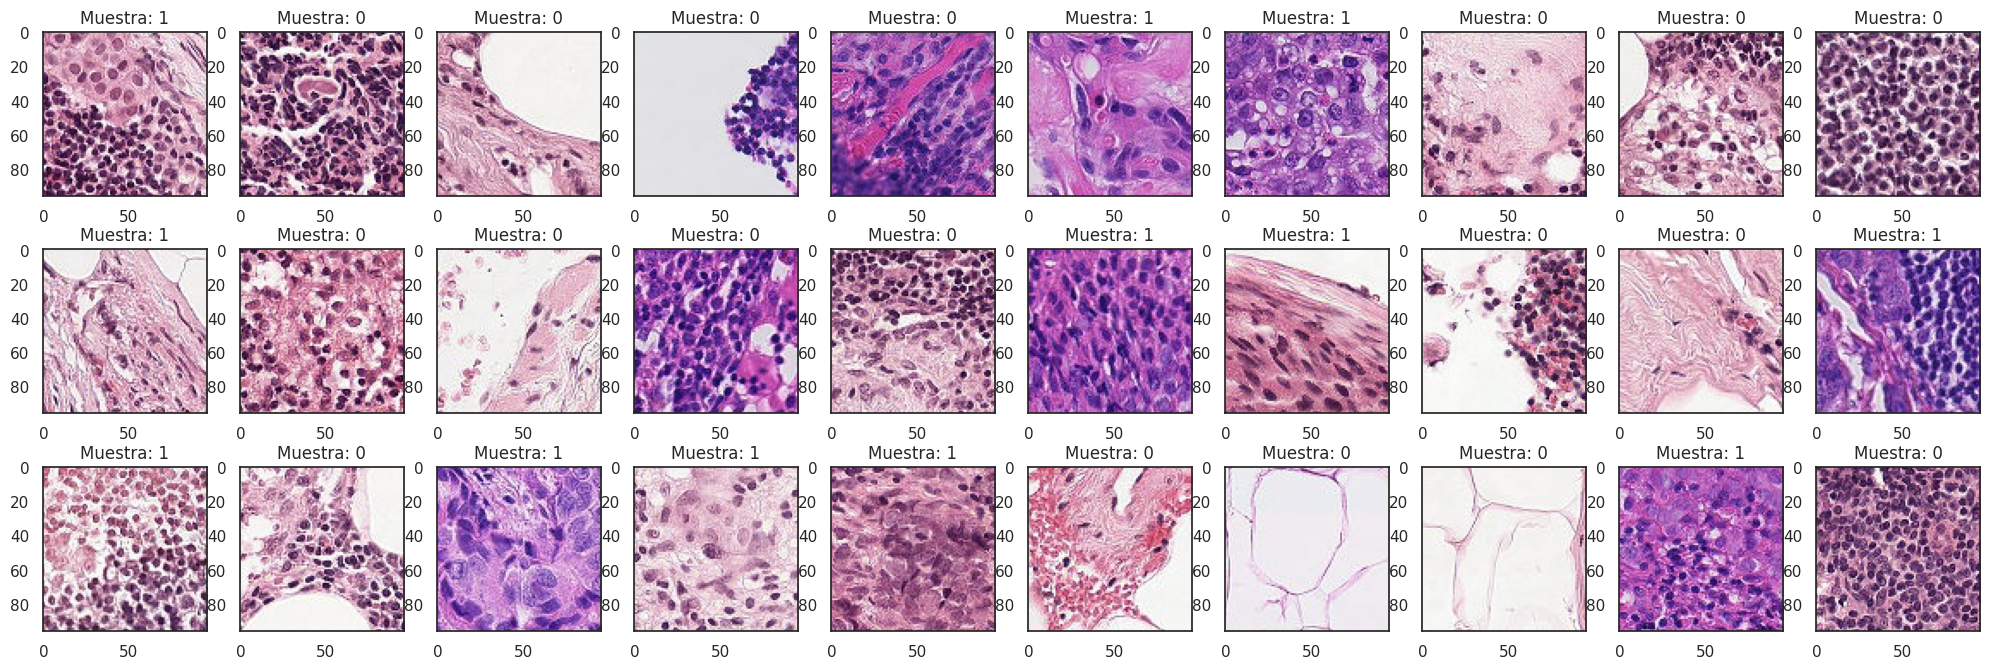

In [18]:
# Crear una figura con un tamaño de 25 por 8 pulgadas
fig = plt.figure(figsize=(25, 8))

# Establecer la ruta a la carpeta de datos de entrenamiento
path2data = "data_sample/data_sample"

# Obtener una lista de todos los archivos de imagen en la carpeta de datos de entrenamiento
train_imgs = os.listdir(path2data)

# Recorrer un subconjunto de 30 imágenes elegiendo al azar.
for idx, img in enumerate(np.random.choice(train_imgs, 30)):

    # Agregar una trama secundaria a la figura
    # Especifica que habrá 3 filas y 10 columnas de subtramas
    ax = fig.add_subplot(3, 30//3, idx+1)

    # Abrir el archivo de imagen actual
    im = Image.open(path2data + "/" + img)

    # Mostrar la imagen en la trama secundaria actual
    plt.imshow(im)

   # Extraer la etiqueta de la imagen actual de un DataFrame
   # Que tiene una columna de identificadores de imágenes y sus etiquetas correspondientes
    lab = labels_df.loc[labels_df["id"] == img.split('.')[0], 'label'].values[0]

    #Establece el título de la trama secundaria actual en la etiqueta de la imagen
    ax.set_title(f'Muestra: {lab}')

## **Preparación de los datos**

>> Crearemos una clase cancer_dataset para cargar imágenes y sus etiquetas correspondientes para una tarea de clasificación binaria usando PyTorch.


In [19]:
class cancer_dataset(Dataset):

    def __init__(self, data_dir, transform, dataset_type=None):
        # Obtener la ruta al directorio que contiene las imágenes
        path2data = os.path.join(data_dir, "data_sample/data_sample")

        # Obtener una lista de los nombres de archivo de las imágenes en el directorio
        filenames = os.listdir(path2data)

        # Obtener la ruta completa de cada imagen
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]

        # Cargar las etiquetas desde un archivo CSV
        path2labels = os.path.join(data_dir, "labels.csv")
        labels_df = pd.read_csv(path2labels)

        # Establecer la columna "id" como índice para el dataframe de etiquetas
        labels_df.set_index("id", inplace=True)

        # Obtener las etiquetas para el conjunto de datos
        if dataset_type=="train":
            # Utilizar solo un subconjunto de las imágenes para entrenamiento
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames][0:3608]
            self.full_filenames = [os.path.join(path2data, f) for f in filenames][0:2608]
            print("training dataset")

        elif dataset_type=="val":
            # Utilizar solo un subconjunto de las imágenes para validación
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames][3608:3648]
            self.full_filenames = [os.path.join(path2data, f) for f in filenames][3508:3648]
            print("validation dataset")

        elif dataset_type=="test":
            # Utilizar solo un subconjunto de las imágenes para pruebas
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames][3648:-1]
            self.full_filenames = [os.path.join(path2data, f) for f in filenames][3648:-1]
            print("testing dataset")

        else:
            # Utilizar todas las imágenes para el conjunto de datos
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]

        # Guardar la transformación de datos que se aplicará a cada imagen
        self.transform = transform

    def __len__(self):
        # Devolver el tamaño del conjunto de datos (es decir, el número de imágenes)
        return len(self.full_filenames)

    def __getitem__(self, idx):
        # Abrir el archivo de imagen y aplicar la transformación de datos
        img = Image.open(self.full_filenames[idx]) # Imagen de PIL
        img = self.transform(img)

        # Devolver la imagen transformada junto con su etiqueta
        return img, self.labels[idx]

## **Transformar el conjunto de datos**

<p align="justify">
Ahora podría estar pensando: ¿no se entrenará el modelo solo para reconocer esas imágenes exactas con este conjunto de datos?
</p>

<p align="justify">
Aquí es donde entra en juego el preprocesamiento de imágenes. Queremos entrenar el modelo con más datos. Una forma de hacerlo es crear copias de la imagen y transformar esas copias. Este proceso ayuda al modelo a reconocer un objeto en lugar de solo la imagen en sí. Por ejemplo, podemos voltear verticalmente una imagen. El objeto de la imagen no cambia. Si giramos esa imagen 5 grados, el objeto de la imagen tampoco cambia.
</p>

<p align="justify">
Las CNN previamente entrenadas se han entrenado con grandes cantidades de datos, normalmente con muchas más clases. Un ejemplo de tal conjunto de datos es ImageNet. Con estas CNN, podemos simplemente reemplazar su última capa con un clasificador lineal, a veces llamado capa personalizada. En lugar de tener sólo dos dimensiones, esta capa lineal tendrá cientos de dimensiones. Entonces podremos entrenar solo la capa lineal. Este es un tipo de aprendizaje por transferencia y es una excelente manera de obtener buenos resultados con relativamente poco trabajo.
</p>

<p align="justify">
Para hacer esto con nuestro conjunto de datos, crearemos un proceso de transformación llamado "compuesto". Esto creará copias de las imágenes redimensionadas, volteadas y rotadas horizontalmente. También convertiremos las imágenes a un tensor y normalizaremos sus canales de imagen.
</p>

Crearemos transformadores para convertir imágenes PIL en tensores PyTorch.

In [25]:
from torchvision import transforms

# Transformación de datos:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
composed_train = transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomRotation(degrees=5),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std)
                               ])

# Esta transformación es para validaciones y conjuntos de prueba.
composed= transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std)
                               ])

>> Aquí, obtenemos una lista de archivos en un directorio específico y almacenamos sus nombres de archivos como una lista en Python.

In [ ]:
import os
from os import listdir
from os.path import isfile, join

# Definir ruta al directorio
mypath = "/resources/data_sample/data_sample"

# Obtener una lista de solo nombres de archivos en el directorio
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

# Iterar a través de cada elemento en la lista de contenidos del directorio devuelto por la función listdir
# Comprobar si el elemento es un archivo usando la función isfile
# Si el elemento es un archivo, agréguelo a la lista de archivos únicos usando la función de unión para crear la ruta completa al archivo

In [30]:
labels_df

id  label
0       f38a6374c348f90b587e046aac6079959adf3835      0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2       755db6279dae599ebb4d39a9123cce439965282d      0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4       068aba587a4950175d04c680d38943fd488d6a9d      0
...                                          ...    ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

[220025 rows x 2 columns]

>> Con la práctica clase que creamos anteriormente, ahora podemos crear un objeto dataset_full, una instancia de la clase Cancer_dataset.

In [31]:
# Carguemos el conjunto de datos y veamos una muestra.

data_dir = "./"
dataset_full = cancer_dataset(data_dir , transform=composed)

In [32]:
img, label = dataset_full [19]
print(img.shape, torch.min(img), torch.max(img))

torch.Size([3, 224, 224]) tensor(-1.4055) tensor(2.6400)


## **Dividiendo el conjunto de datos**

<p align="justify">
Dividamos este conjunto de datos de entrenamiento en tres partes: entrenamiento, validación y prueba. Quizás se pregunte, ¿por qué dividimos el conjunto de datos de esta manera?
</p>

<p align="justify">
Piénselo de esta manera: el conjunto de capacitación es similar a las preguntas de práctica que se ofrecen en la escuela. Le ayudan a aprender y mejorar al responder las preguntas. El conjunto de validación es similar a un examen parcial y se utiliza para confirmar sus conocimientos y ofrecerle comentarios sobre su desempeño hasta el momento. Finalmente, el conjunto de pruebas es similar a un examen final. Le pone a prueba su desempeño después de todo el proceso de aprendizaje cuando se enfrenta a preguntas que quizás nunca antes haya visto.
</p>

<p align="justify">
Para entrenar el modelo, usaremos datos de la primera parte del conjunto de datos de entrenamiento. Para validar esos datos calculando métricas como la pérdida de validación, usaremos datos de la segunda parte del conjunto de datos. Finalmente, probaremos el modelo con la tercera parte del conjunto de datos utilizando imágenes que no se han visto antes.
</p>

<p align="justify">
A continuación, utilizamos el 70% de nuestro conjunto de datos para capacitación, el 15% para validación y el 15% restante para pruebas. Cuando construimos nuestra clase de conjunto de datos, incluimos como uno de los parámetros.
</p>

In [33]:
# Creando el objeto cancer_dataset para entrenamiento, prueba y validación.
training_set=cancer_dataset(data_dir , transform=composed_train,dataset_type="train")
validation_set=cancer_dataset(data_dir , transform=composed,dataset_type="val")
test_set=cancer_dataset(data_dir , transform=composed,dataset_type="test")
print(f'training dataset length: {len(training_set)}')
print(f'validation dataset length: {len(validation_set)}')
print(f'test dataset length: {len(test_set)}')

training dataset
validation dataset
testing dataset
training dataset length: 2608
validation dataset length: 140
test dataset length: 360


>> Podemos trazar una muestra de los datos de entrenamiento, vemos que cada vez cambia ligeramente de forma aleatoria.

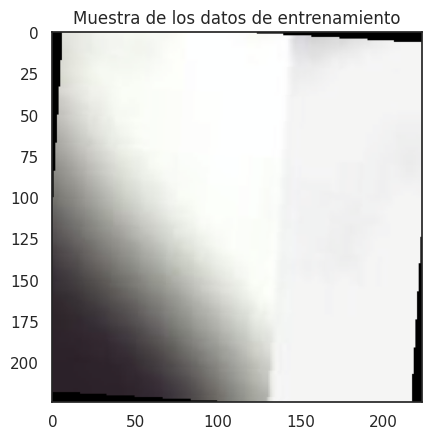

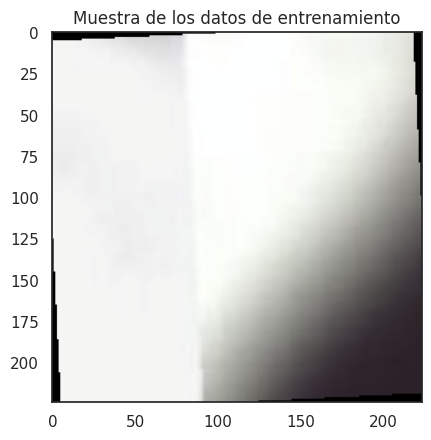

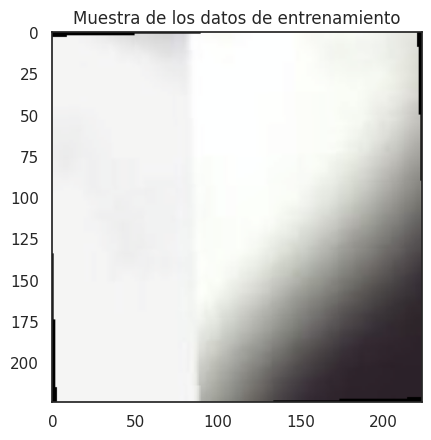

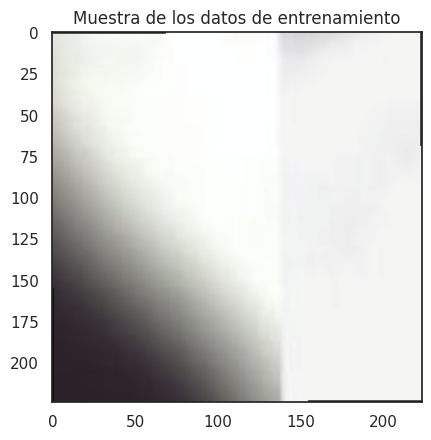

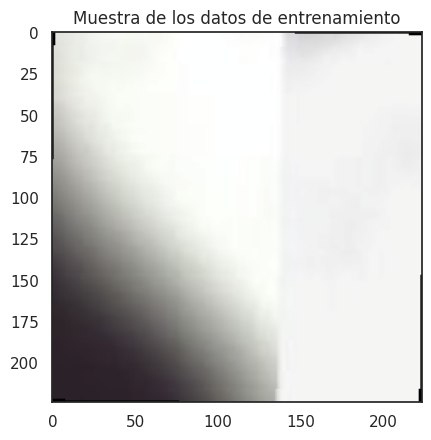

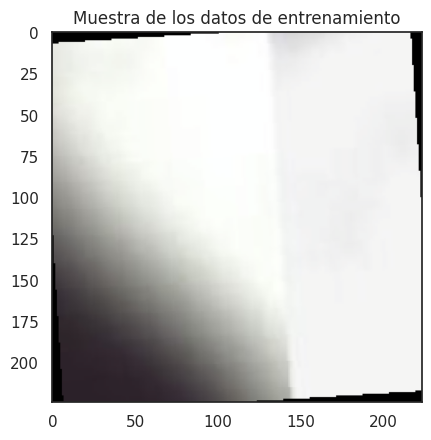

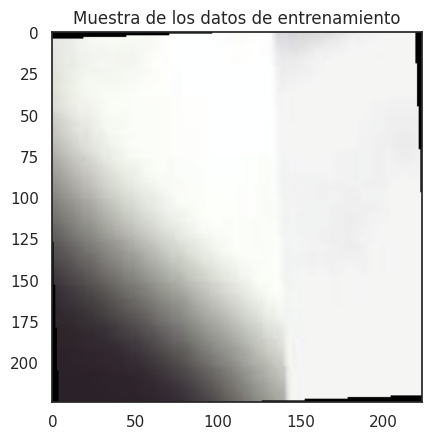

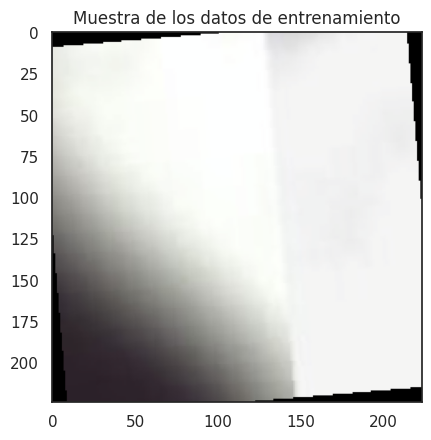

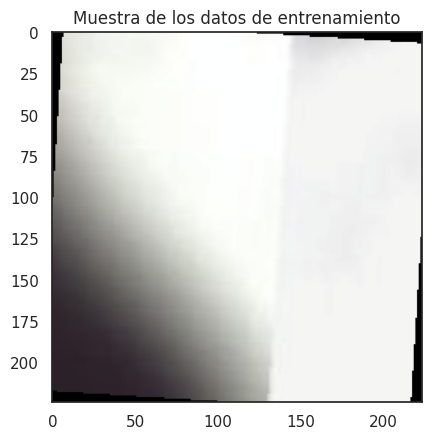

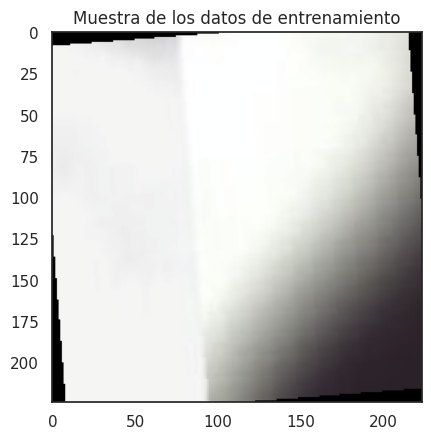

In [35]:
for i in range(10):
    plt.title("Muestra de los datos de entrenamiento")
    imshow(training_set[2][0])


>> Las imágenes de prueba y validación son las mismas.

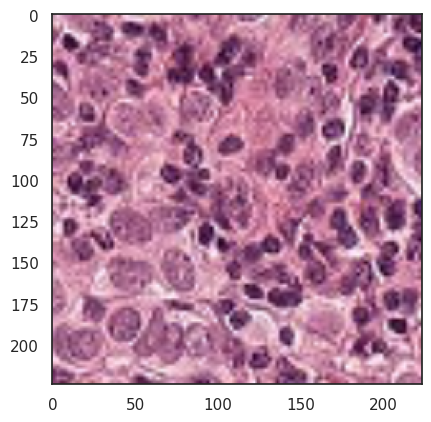

In [36]:
imshow(test_set[0][0])

## **Pytorch DataLoader**

<p align="justify">
PyTorch DataLoader es una utilidad que ayuda a cargar e iterar sobre un conjunto de datos durante el entrenamiento y evaluación de modelos de aprendizaje profundo. Proporciona una interfaz iterable para el conjunto de datos y realiza una carga de datos multiproceso, lo que mejora la velocidad de carga de datos, especialmente cuando los datos se almacenan en el disco o en una ubicación remota.
</p>

<p align="justify">
Un DataLoader puede mezclar los datos antes de cada época, aplicar transformaciones a los datos y combinar varios lotes de datos en un solo lote. Se puede configurar el tamaño del lote y la cantidad de procesos de trabajo que cargan los datos, lo que puede ayudar a optimizar el uso de la memoria y la velocidad de carga de los datos. PyTorch DataLoader es una forma flexible y eficiente de manejar grandes conjuntos de datos y se usa comúnmente en proyectos de aprendizaje profundo.
</p>


In [37]:
# Cargar datos
train_loader = torch.utils.data.DataLoader(training_set, batch_size=10, shuffle=True, num_workers=2)

# No usamos validación en este proyecto, pero se recomienda usarla para su futuro procedimiento de capacitación.
# val_loader = torch.utils.data.DataLoader(validation_set, lote_size=10, shuffle=False, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=10, shuffle=False, num_workers=2)

# Definir clases
num_classes = 2
print("done")

done


In [38]:
#Tamaño del lote: conjunto de trenes
batch_size = 30

#Tasa de aprendizaje
lr = 3e-4

# Épocas numéricas
n_epochs = 5

In [39]:
from torchvision import models
model = models.resnet34(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 78.3MB/s]


In [40]:
from torch.nn import CrossEntropyLoss
criterion = CrossEntropyLoss()

In [41]:
from torch.optim import Adam
optimizer = Adam(model.parameters(), lr = lr)

In [42]:
num_classes = 2

#Cargar modelo previamente entrenado
model = models.resnet34(pretrained=True)

#Congelar capas
for param in model.parameters():
    param.requires_grad = False

#Modificar la última capa
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

In [47]:
# Entrenar el modelo
for epoch in range(2): # Iterar a través de una sola época
    running_loss = 0.0 # Inicializar variable para rastrear la pérdida

    # Iterar sobre los datos de entrenamiento usando un DataLoader de PyTorch
    for i, data in enumerate(tqdm(train_loader)):
        # Extraer entradas y etiquetas de los datos
        inputs, labels = data

        # Poner a cero los gradientes en el optimizador
        optimizer.zero_grad()

        # Paso hacia adelante a través del modelo
        outputs = model(inputs)

        # Calcular la pérdida entre las salidas del modelo y las etiquetas
        loss = criterion(outputs, labels)

        # Retropropagar la pérdida y calcular gradientes
        loss.backward()

        # Actualizar los parámetros del modelo usando el optimizador
        optimizer.step()

        # Actualizar la pérdida acumulada con la pérdida del lote actual
        running_loss += loss.item()

        # Imprimir la pérdida promedio cada 100 iteraciones
        if i % 100 == 99:
            tqdm.write('[%d, %5d] pérdida: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0 # Restablecer la pérdida acumulada para las siguientes 100 iteraciones

 38%|███▊      | 100/261 [02:57<04:43,  1.76s/it]

[1,   100] pérdida: 0.749


 77%|███████▋  | 200/261 [05:52<01:41,  1.67s/it]

[1,   200] pérdida: 0.758


 38%|███▊      | 100/261 [02:53<04:43,  1.76s/it]

[2,   100] pérdida: 0.771


 77%|███████▋  | 200/261 [05:46<01:40,  1.64s/it]

[2,   200] pérdida: 0.756


100%|██████████| 261/261 [07:31<00:00,  1.73s/it]


In [48]:
######### --------------------- Probar el modelo ----------------------- ########################

correct = 0 # Inicializar variable para llevar la cuenta de imágenes clasificadas correctamente
total = 0 # Inicializar variable para llevar la cuenta del total de imágenes

# Usar el modelo para inferencia y deshabilitar el seguimiento de gradientes
with torch.no_grad():
    for data in tqdm(test_loader): # Iterar sobre los datos de prueba usando un DataLoader de PyTorch
        images, labels = data # Extraer imágenes y etiquetas de los datos

        # Paso hacia adelante a través del modelo para obtener predicciones
        outputs = model(images)

        # Encontrar las clases predichas a partir de las salidas del modelo
        # tomando la clase con la puntuación más alta
        _, predicted = torch.max(outputs.data, 1)

        # Actualizar el conteo total de imágenes vistas
        total += labels.size(0)

        # Actualizar el conteo de imágenes clasificadas correctamente
        correct += (predicted == labels).sum().item()

# Calcular e imprimir la precisión del modelo en el conjunto de prueba
print('Precisión de la red en las imágenes de prueba: %d %%' % (100 * correct / total))

100%|██████████| 36/36 [01:01<00:00,  1.72s/it]

Precisión de la red en las imágenes de prueba: 53 %


>> **Precisión de la red en las imágenes de prueba: 53%:**

<p align="justify">
Esta frase reporta el rendimiento final del modelo en el conjunto de datos de prueba. La "precisión" se refiere al porcentaje de predicciones correctas hechas por el modelo sobre el total de predicciones. En este caso, el modelo logró una precisión del 53%.
En resumen, después de evaluar todos los lotes del conjunto de datos de prueba, el modelo logró identificar correctamente un poco más de la mitad de las imágenes o ítems. Una precisión del 53% sugiere que el modelo es relativamente mejor que una selección aleatoria (en clasificaciones binarias, por ejemplo, donde el azar tendría una precisión esperada del 50%), pero aún hay margen significativo para mejorar su capacidad de predicción. Dependiendo del contexto y de la dificultad de la tarea, un 53% podría ser insuficiente, y sería recomendable investigar métodos para mejorar el rendimiento del modelo, como ajustar la arquitectura del modelo, utilizar más datos de entrenamiento, o aplicar técnicas de aumento de datos.
</p>